### 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from pandas_datareader import data
import datetime

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.optimize import minimize

### 2. Setting Tickers and Functions

In [2]:
# Market Capitalization Top-Ranked Companies in U.S.
tickers = ['AAPL', 'ADBE', 'AMZN', 'BAC', 'CMCSA', 'CSCO', 'CVX', 'DIS',
           'GOOG', 'HD', 'INTC', 'JNJ', 'JPM', 'KO', 'MA', 'MSFT', 'NFLX', 'NKE',
           'NVDA', 'ORCL', 'PFE', 'PG', 'T', 'TM', 'TSLA', 'UNH', 'V', 'VZ', 'WMT',
           'XOM']

In [3]:
# Setting Device - If you have gpu, you can change the device 'gpu'
device = torch.device('cpu')

In [4]:
# Make Class of LSTM Model
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

In [5]:
def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred))))

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

### 3. Setting Hyperparameters and Training Data

In [6]:
num_epochs = 10000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes 

In [7]:
df_results_lstm = pd.DataFrame()
df_metrics_lstm = pd.DataFrame()

In [8]:
# Data loading
start = (2010, 1, 1) 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) 
end_time = datetime.datetime(*end) 

In [9]:
for i in range(len(tickers)):
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
    df = pdr.DataReader(tickers[i], 'yahoo', start_time, end_time)

    df_s = pd.DataFrame()
    
    df_s['High'] = (df['High'] - df['High'].min())/(df['High'].max() - df['High'].min())
    df_s['Low'] = (df['Low'] - df['Low'].min())/(df['Low'].max() - df['Low'].min())
    df_s['Open'] = (df['Open'] - df['Open'].min())/(df['Open'].max() - df['Open'].min())
    df_s['Close'] = (df['Close'] - df['Close'].min())/(df['Close'].max() - df['Close'].min())
    df_s['Volume'] = (df['Volume'] - df['Volume'].min())/(df['Volume'].max() - df['Volume'].min())
    df_s['Adj Close'] = (df['Adj Close'] - df['Adj Close'].min())/(df['Adj Close'].max() - df['Adj Close'].min())
    
    X = np.array(df_s) # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
    y = np.array(df_s.iloc[:, 5:6]) #Predicting adjusted close price

    train_pct = 0.8
    split = int(train_pct * len(X))
    X_train, X_test, y_train, y_test = X[:split, :], X[split+1:-1 :], y[1:split+1, :], y[split+2:, :] 

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

    loss_function = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate)  # adam optimizer

    print(tickers[i])
    for epoch in range(num_epochs+1):
        outputs = LSTM_1.forward(X_train_tensors_final.to(device)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = loss_function(outputs, y_train_tensors.to(device))

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop

        if epoch % 1000 == 0:
            print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item()))

    X_data = X_test
    y_data = y_test

    df_X = Variable(torch.Tensor(X_data))
    df_y = Variable(torch.Tensor(y_data))

    df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
    train_predict = LSTM_1(df_X.to(device))#forward pass
    y_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
    
    y_predict = y_predict * (df['Adj Close'].max() - df['Adj Close'].min()) + df['Adj Close'].min() #reverse transformation
    y_true = np.array(df.iloc[split+2:, 5:6])
    
    metrics_value_lstm = pd.DataFrame([MAE(y_true, y_predict), MSE(y_true, y_predict), RMSE(y_true, y_predict), MAPE(y_true, y_predict), MPE(y_true, y_predict)])
    metrics_value_lstm.columns = [tickers[i]]
    metrics_value_lstm.index = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE']
    df_metrics_lstm = pd.concat([df_metrics_lstm, metrics_value_lstm], axis = 1)
    df_results_lstm_temp = pd.DataFrame(y_predict)
    df_results_lstm_temp.columns = [tickers[i]]
    df_results_lstm = pd.concat([df_results_lstm, df_results_lstm_temp], axis=1)

AAPL
Epoch: 0, Loss: 0.0110
Epoch: 1000, Loss: 0.0000
Epoch: 2000, Loss: 0.0000
Epoch: 3000, Loss: 0.0000
Epoch: 4000, Loss: 0.0000
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000
ADBE
Epoch: 0, Loss: 0.1854
Epoch: 1000, Loss: 0.0001
Epoch: 2000, Loss: 0.0000
Epoch: 3000, Loss: 0.0000
Epoch: 4000, Loss: 0.0000
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000
AMZN
Epoch: 0, Loss: 0.8747
Epoch: 1000, Loss: 0.0199
Epoch: 2000, Loss: 0.0006
Epoch: 3000, Loss: 0.0002
Epoch: 4000, Loss: 0.0001
Epoch: 5000, Loss: 0.0001
Epoch: 6000, Loss: 0.0001
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000
BAC
Epoch: 0, Loss: 0.4673
Epoch: 1000, Loss: 0.0010
Epoch: 2000, Loss: 0.0004
Epoch: 3000, Loss: 0.0002
Epoch: 4000, Loss: 0.0002
Ep

### 4-1. Saving Metrics

In [10]:
df_metrics_lstm.to_csv('Results of Error Metrics (LSTM).csv', encoding = 'utf-8-sig')

### 4-2. Building Datasets

In [11]:
df_results_lstm.index = df.iloc[len(df) - len(df_results_lstm):, ].index

In [12]:
df_original = pd.DataFrame()

for i in range(len(tickers)):
    df = pdr.DataReader(tickers[i], 'yahoo', start_time, end_time)
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
    close = df['Adj Close']
    df_close = pd.DataFrame(close)
    df_close.columns = [tickers[i]]
    df_original = pd.concat([df_original, df_close], axis=1)

ret_daily = df_results_lstm.pct_change()
ret_daily = ret_daily.iloc[1:, ]

ret_daily_original = df_original.iloc[len(df) - len(df_results_lstm) - 251:, ]
ret_daily_original = ret_daily_original.pct_change()
ret_daily_original = ret_daily_original.iloc[1:, ]

n_assets = len(tickers)

In [13]:
# df_original = pd.DataFrame()

# for i in range(len(tickers)):
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
#     close = df['Adj Close']
#     df_close = pd.DataFrame(close)
#     df_close.columns = [tickers[i]]
#     df_original = pd.concat([df_original, df_close], axis=1)

### 5-1. Portfolio Optimization with Stock Price Prediction Results

In [14]:
def obj_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return 1/((ret-rf)/np.sqrt(vol)) # 1/Sharpe Ratio -> Maximize Sharpe Ratio Using Minimize Function

In [15]:
portfolio_lstm = []
for i in range(0, len(ret_daily)-1):
    ret_annual = pd.concat([ret_daily_original[i:i+251], ret_daily[i:i+1]]).mean() * 252
    cov_annual = pd.concat([ret_daily_original[i:i+251], ret_daily[i:i+1]]).cov() * 252
    rf = 0.01
    w0 = np.ones([n_assets])/n_assets
    bnds = tuple((0., 1.) for i in range(n_assets))
    cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
    res = minimize(obj_sharpe, w0, (ret_annual, cov_annual, rf), method='SLSQP', bounds=bnds, constraints=cons)
    profit = (ret_daily_original.iloc[i+252] * res.x).sum()
    portfolio_lstm.append(profit)
    print(profit)

0.06722184485408164
-0.0781967948711711
-0.06326358495756708
-0.0007208013169429863
0.008201595472497311
0.012767033031882919
-0.011969132791661816
-0.001738544764417311
-0.0011499911256416541
0.026438086865599956
-0.0032358537049815084
-0.021650438009148013
-0.01981821842655384
-0.0015368084666342
-0.0040064078807915985
0.00398865002037449
0.0084109292573051
-0.012654008826407877
-0.016969084761045312
-0.007098038723912041
-0.009506918323738647
0.021281560176441
0.0212409331102213
0.016936593329708285
-0.0014303993460600174
0.001461134335245309
0.014573735151854226
-0.03582289975929333
0.018223388654163813
-0.041925197290109725
0.016108993665981543
-0.0021902329761785905
0.008377939721541425
0.00516155348105219
-0.0429966787612077
-0.0285741497974192
0.02920599325361478
-0.01539091087697006
-0.02320351874788057
-0.05445539916275177
-0.05077314232649638
0.055533505374638234
0.00749008226825491
0.0011339178690512035
0.04434811032847149
-0.0005975968917705925
0.013225765875353051
0.07835

In [16]:
portfolio_lstm = pd.DataFrame(portfolio_lstm) - 0.0003 # Upper bound of security transaction tax
portfolio_lstm.index = ret_daily.index[1:]
portfolio_lstm.columns = ['Portfolio Return']

data_lstm = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_lstm.index = data_lstm['Date']
data_lstm = data_lstm.drop(['Date'], axis=1)

portfolio_lstm = pd.concat([data_lstm, portfolio_lstm])

In [17]:
c_return_lstm = []

for i in range(0, len(portfolio_lstm)):
    if i == 0:
        c_return_lstm_v_init = 0
        c_return_lstm.append(c_return_lstm_v_init)
    else:
        c_return_lstm_v = (c_return_lstm[i-1] + 1) * (portfolio_lstm['Portfolio Return'][i] + 1) - 1
        c_return_lstm.append(c_return_lstm_v)
        
c_return_lstm = pd.DataFrame(c_return_lstm)
c_return_lstm.index = portfolio_lstm.index

portfolio_lstm_final = pd.concat([portfolio_lstm, c_return_lstm], axis = 1)
portfolio_lstm_final.columns = ['Portfolio Return', 'Cumulative Return']

In [18]:
risk_free_rate = 0.015
std_portfolio_lstm = portfolio_lstm_final['Portfolio Return'][1:].std()
Sharpe_lstm = (portfolio_lstm_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_lstm
Sharpe_lstm = Sharpe_lstm.mean()
print('Sharpe ratio (Portfolio with LSTM Price Prediction Results): %.2f' % Sharpe_lstm)

Sharpe ratio (Portfolio with LSTM Price Prediction Results): -0.32


In [19]:
portfolio_lstm_final.tail()

,Portfolio Return,Cumulative Return
Date,,
2020-12-24 00:00:00,0.024144,4.070533
2020-12-28 00:00:00,0.002601,4.083723
2020-12-29 00:00:00,0.003165,4.099815
2020-12-30 00:00:00,0.042929,4.318745
2020-12-31 00:00:00,0.015374,4.400515


### 5-2. Equally-Weighted Portfolio

In [20]:
portfolio_eqw = []

for i in range(0, len(ret_daily)-1):
    weights = np.ones([n_assets])/n_assets
    profit_eqw = (ret_daily_original.iloc[i+252] * weights).sum()
    portfolio_eqw.append(profit_eqw)

portfolio_eqw = pd.DataFrame(portfolio_eqw) 
portfolio_eqw.index = ret_daily.index[1:]
portfolio_eqw.columns = ['Portfolio Return']
    
data_eqw = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_eqw.index = data_eqw['Date']
data_eqw = data_eqw.drop(['Date'], axis=1)

portfolio_eqw = pd.concat([data_eqw, portfolio_eqw])

c_return_eqw = []

for i in range(0, len(portfolio_eqw)):
    if i == 0:
        c_return_eqw_v_init = 0
        c_return_eqw.append(c_return_eqw_v_init)
    else:
        c_return_eqw_v = (c_return_eqw[i-1] + 1) * (portfolio_eqw['Portfolio Return'][i] + 1) - 1
        c_return_eqw.append(c_return_eqw_v)
        
c_return_eqw = pd.DataFrame(c_return_eqw)
c_return_eqw.index = portfolio_eqw.index

portfolio_eqw_final = pd.concat([portfolio_eqw, c_return_eqw], axis = 1)
portfolio_eqw_final.columns = ['Portfolio Return', 'Cumulative Return']

In [21]:
risk_free_rate = 0.015
std_portfolio_eqw = portfolio_eqw_final['Portfolio Return'][1:].std()
Sharpe_eqw = (portfolio_eqw_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_eqw
Sharpe_eqw = Sharpe_eqw.mean()
print('Sharpe ratio (Equally-Weighted Portfolio): %.2f' % Sharpe_eqw)

Sharpe ratio (Equally-Weighted Portfolio): -0.86


In [22]:
portfolio_eqw_final.tail()

,Portfolio Return,Cumulative Return
Date,,
2020-12-24 00:00:00,0.003451,0.667722
2020-12-28 00:00:00,0.008781,0.682366
2020-12-29 00:00:00,0.001416,0.684749
2020-12-30 00:00:00,0.001416,0.687135
2020-12-31 00:00:00,0.005771,0.696872


### 5-3. Capitalization Weighted Portfolio

In [23]:
market_cap_data = data.get_quote_yahoo(tickers)['marketCap']
market_cap = pd.DataFrame(market_cap_data)

In [24]:
market_cap = market_cap / market_cap.sum()

In [25]:
market_cap = np.array(market_cap['marketCap'].tolist())

In [26]:
portfolio_mcw = []

for i in range(0, len(ret_daily)-1):
    weights = market_cap
    profit_mcw = (ret_daily_original.iloc[i+252] * weights).sum()
    portfolio_mcw.append(profit_mcw)

portfolio_mcw = pd.DataFrame(portfolio_mcw) 
portfolio_mcw.index = ret_daily.index[1:]
portfolio_mcw.columns = ['Portfolio Return']

data_mcw = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_mcw.index = data_mcw['Date']
data_mcw = data_mcw.drop(['Date'], axis=1)

portfolio_mcw = pd.concat([data_mcw, portfolio_mcw])

c_return_mcw = []

for i in range(0, len(portfolio_mcw)):
    if i == 0:
        c_return_mcw_v_init = 0
        c_return_mcw.append(c_return_mcw_v_init)
    else:
        c_return_mcw_v = (c_return_mcw[i-1] + 1) * (portfolio_mcw['Portfolio Return'][i] + 1) - 1
        c_return_mcw.append(c_return_mcw_v)
        
c_return_mcw = pd.DataFrame(c_return_mcw)
c_return_mcw.index = portfolio_mcw.index

portfolio_mcw_final = pd.concat([portfolio_mcw, c_return_mcw], axis = 1)
portfolio_mcw_final.columns = ['Portfolio Return', 'Cumulative Return']

In [27]:
risk_free_rate = 0.015
std_portfolio_mcw = portfolio_mcw_final['Portfolio Return'][1:].std()
Sharpe_mcw = (portfolio_mcw_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_mcw
Sharpe_mcw = Sharpe_mcw.mean()
print('Sharpe ratio (Market Capitalization-Weighted Portfolio): %.2f' % Sharpe_mcw)

Sharpe ratio (Market Capitalization-Weighted Portfolio): -0.78


In [28]:
portfolio_mcw_final.tail()

,Portfolio Return,Cumulative Return
Date,,
2020-12-24 00:00:00,0.004530,0.960323
2020-12-28 00:00:00,0.015808,0.991312
2020-12-29 00:00:00,-0.001041,0.989239
2020-12-30 00:00:00,-0.001660,0.985936
2020-12-31 00:00:00,0.002900,0.991695


### 6. Plotting Cumulative Returns of Portfolios

In [29]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 50})
plt.rcParams['lines.linewidth'] = 3

In [30]:
portfolio_lstm_final.index = pd.to_datetime(portfolio_lstm_final.index)
portfolio_eqw_final.index = pd.to_datetime(portfolio_eqw_final.index)
portfolio_mcw_final.index = pd.to_datetime(portfolio_mcw_final.index)

In [31]:
# Plot style
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

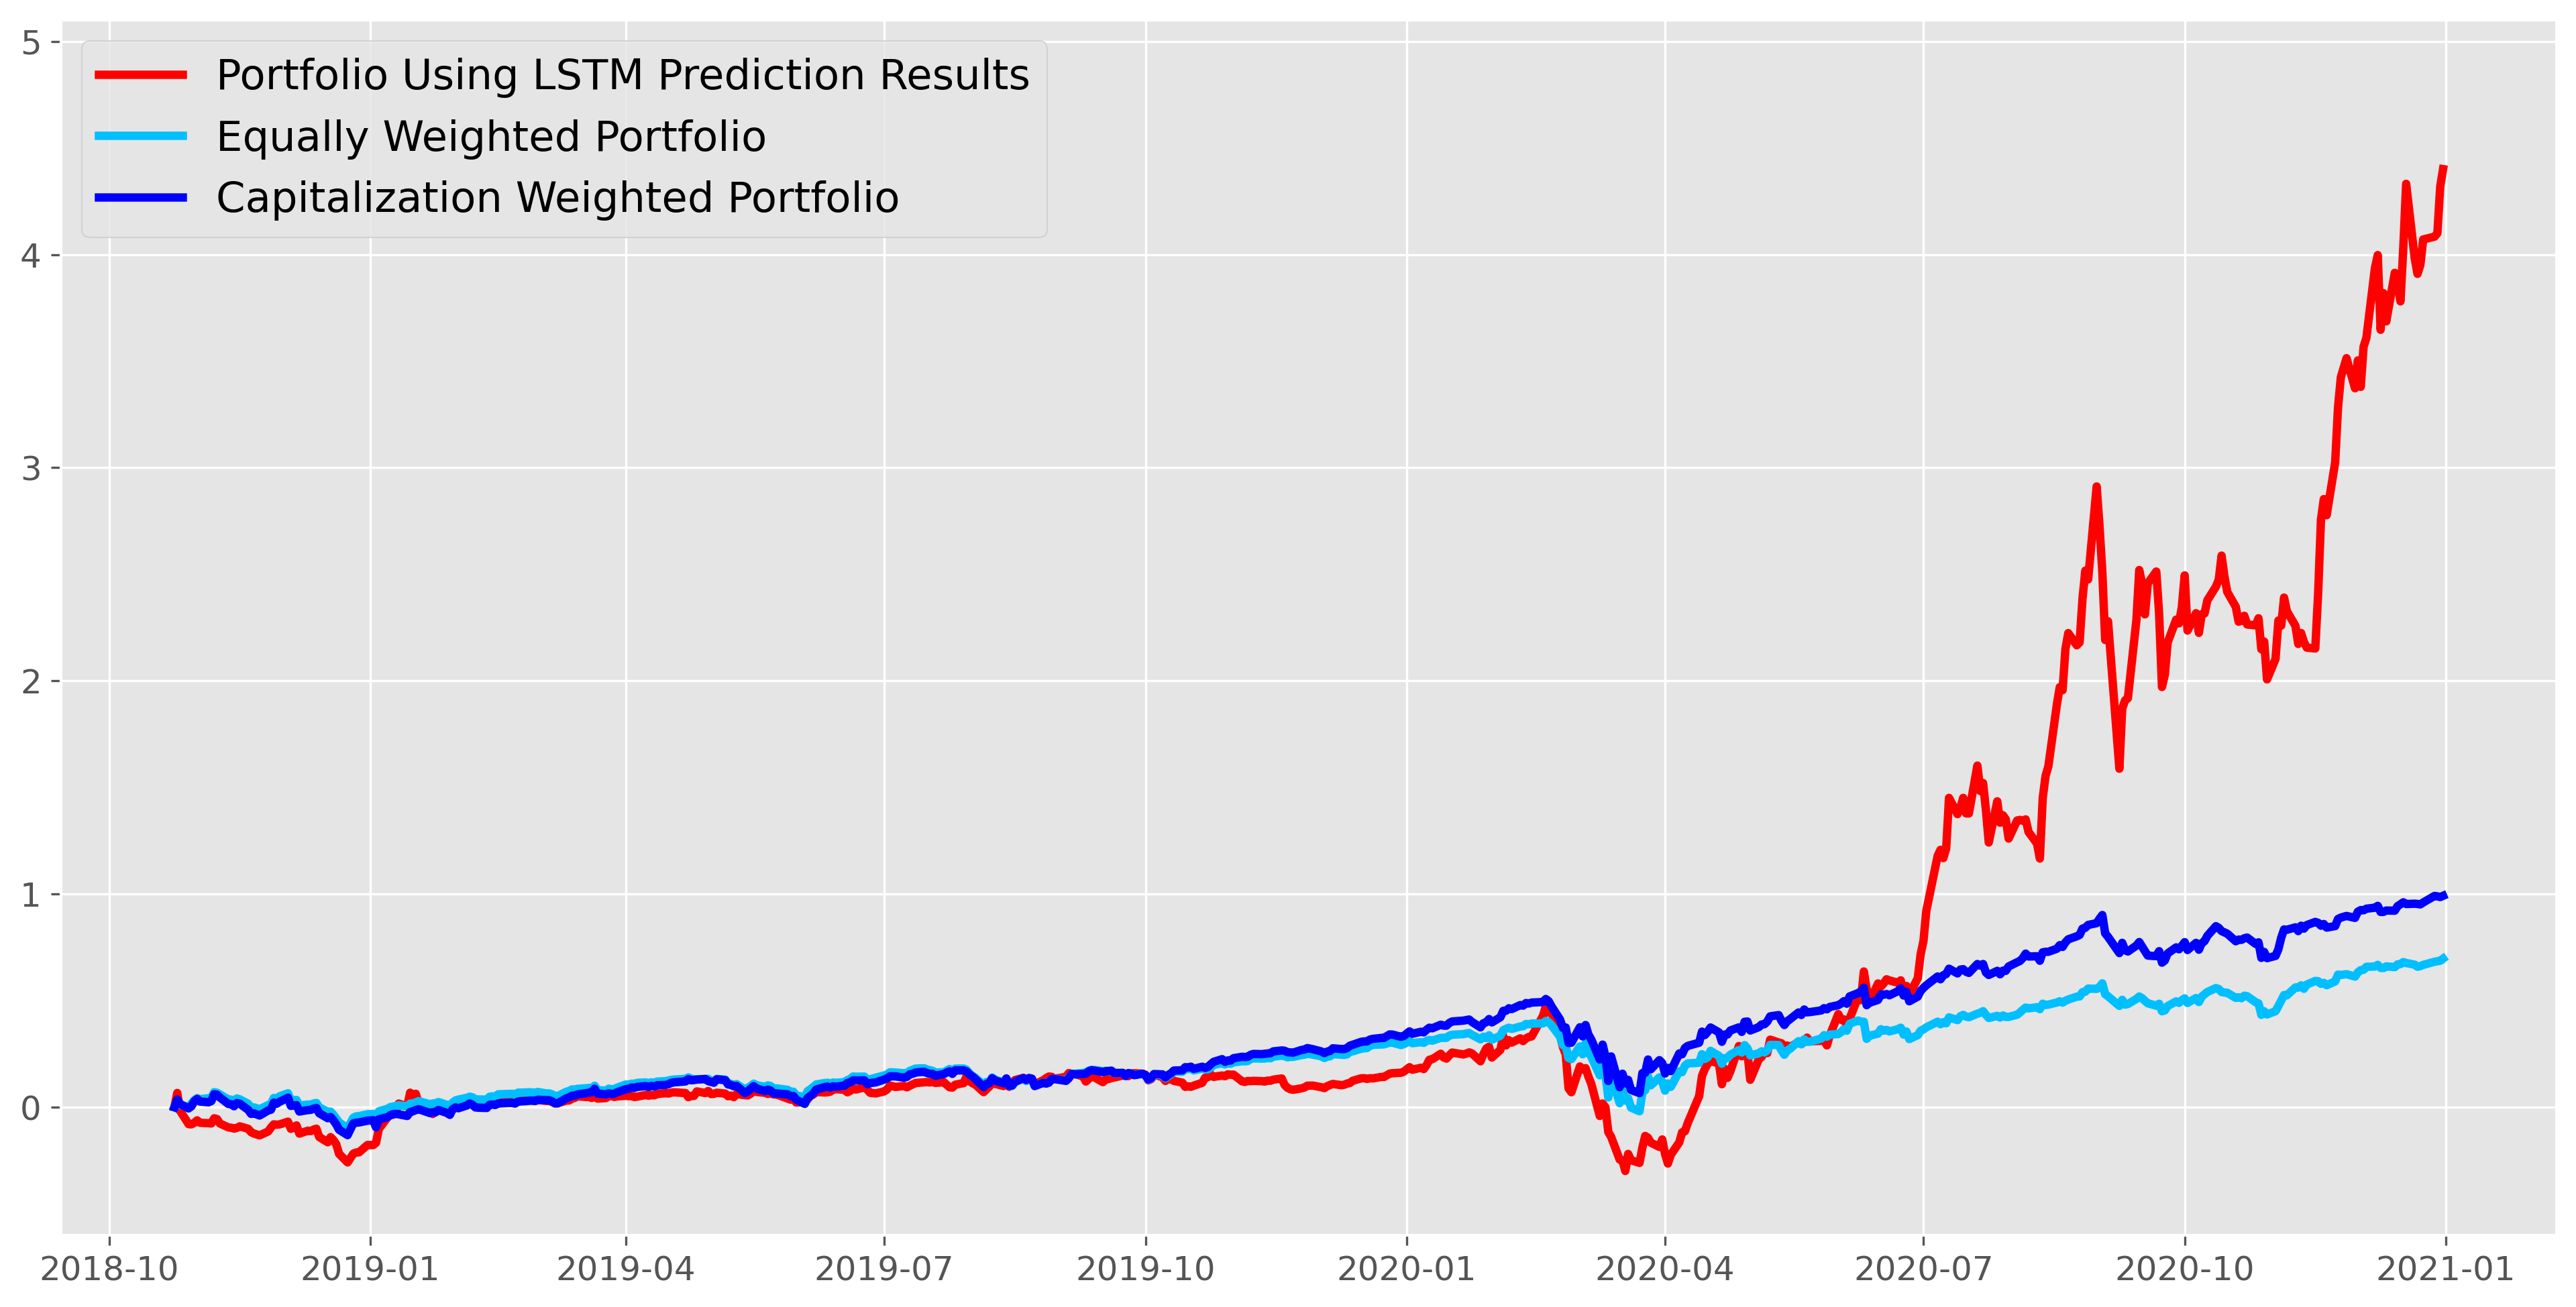

In [32]:
line1 = plt.plot(portfolio_lstm_final.index.to_pydatetime(), portfolio_lstm_final['Cumulative Return'], label = 'Portfolio Using LSTM Prediction Results', color = 'red')
line2 = plt.plot(portfolio_eqw_final.index.to_pydatetime(), portfolio_eqw_final['Cumulative Return'], label = 'Equally Weighted Portfolio', color = 'deepskyblue')
line3 = plt.plot(portfolio_mcw_final.index.to_pydatetime(), portfolio_mcw_final['Cumulative Return'], label = 'Capitalization Weighted Portfolio', color = 'blue')
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(-0.6, 5.1)
plt.legend(prop={'size':15})
plt.savefig('images/portfolio_lstm.pdf', bbox_inches='tight')
plt.show()